In [242]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline

# Использование ЦПТ

### Можно воспользоваться ЦПТ и получить доверительный интервал для среднего

#### Напоминание ЦПТ:
Пусть $\xi_1, \xi_2, \dots$ - независимые одинаково распределённые случайные величины с конечной дисперсией $D \xi_1$ и мат. ожиданием $E \xi_1$, тогда

$\sqrt{\frac{n}{D \xi_1}} \left(\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - E \xi_1\right) \to_{n \to \infty} \mathcal{N}(0, 1)$ 

Отсюда можно сделать вывод, что при больших $n$ величина $\frac{\sum\limits_{i=1}^{n} \xi_i}{n}$ будет распределена примерно как $\mathcal{N}(E \xi_1, \frac{D \xi_1}{n})$

Если бы мы знали $D \xi_1$, то отсюда можно получить интервал на $E \xi_1$:
$$
P\left(E \xi_1 \in \left[\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - 1.96 \sqrt{\frac{D \xi_1}{n}}, \frac{\sum\limits_{i=1}^{n} \xi_i}{n} + 1.96 \sqrt{\frac{D \xi_1}{n}}\right]\right) \approx 0.95
$$

$D \xi_1$ можно оценить по выборке

In [58]:
def get_95_interval(data, sigma=None):
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))
    return mean - err, mean + err

Проверим, что нужное нам значение лежит в интервале с требуемой вероятностью

Требуется проверить как будет работать ЦПТ для для бернулевских (scipy.stats.bernoulli) случайных величин на маленьких выборках (до 10 элементов).

In [321]:
hits = 0.
count = 0.
true_mean = 0.5
binom_size = 10

for _ in range(1000):
    data = np.random.binomial(1, 0.5, size=binom_size)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.885


Подставим реальное значение дисперсии - без ощутимых изменений

In [317]:
hits = 0.
count = 0.
true_mean = 0.5
binom_size = 10

for _ in range(1000):
    data = np.random.binomial(1, 0.5, size=binom_size)
    lower_bound, upper_bound = get_95_interval(data, sigma = 0.5)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.97


воспользуемся "Binomial proportion confidence interval"

In [325]:
hits = 0.
count = 0.
true_mean = 0.5
binom_size = 10

for _ in range(1000):
    data = np.random.binomial(1, 0.5, size=binom_size)
    lower_bound, upper_bound = proportion_confint(data.sum(), binom_size, alpha=0.05)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(hits / count)

0.904


# Bootstap

In [153]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

p-value. С вероятностью 95% эффект находится в заданном интервале. T test дает неудовлетворительный результат - мы нем можем отвергнуть гипотезу, что средние различны

0.155587969561


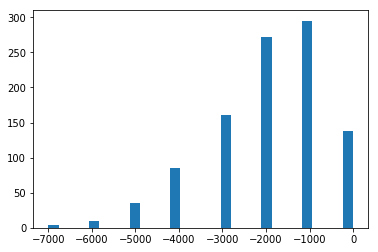

[-5000.13800809    -9.56046724]


In [219]:
data_fst = np.random.normal(0, 10, size=1000)
data_fst = np.append(data_fst,[[-1000000, -1000000]])
data_snd = np.random.normal(10, 10, size=1000)

#T test - 2 independent samples have identical average (expected) values
print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

оцениваем мощность. При корректности Ho (средние - разные), можность критерия - 0, поскольку при Bootstrap  выбросы всегда попадают в выборку

In [226]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    data_fst = np.append(data_fst,[[-1000000, -1000000]])

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
#    print (lower, upper)
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.0


оцениваем корректность. p.value > 0.05 при некорректности Ho, Ho (у выборок разное среднее) не может быть отвергнута. Bootstrap подвержен выбросам

In [241]:
hits = 0.
count = 0.

for _ in range(100):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    data_fst = np.append(data_fst,[[-1000000, -1000000]])

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
#    print (lower, upper)
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.23


# Перестановочные тесты

In [205]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

мощность/корректность критерия. При нулевой гипотезе Ho, что средние разные. перестановочный тест не дает нам оснований утверждать, что гипотезу можно принять или отвергнуть, поскольку корректность и мощность = 0. перестановочный тест так же подвержен выброам, поскольку они попадают в сгенерированные выборки

In [239]:
hits = 0.
count = 0.

for _ in range(100):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    data_fst = np.append(data_fst,[[-1000000, -1000000]])

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


In [240]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    data_fst = np.append(data_fst,[[-1000000, -1000000]])

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0
